# EDA of Zomato restaurants dataset

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from folium.plugins import HeatMap
import folium
import json
from pandas.io.json import json_normalize
from collections import Counter
from IPython.display import display

import plotly.graph_objects as go
import plotly.express as px
sns.set()
import plotly
plotly.offline.init_notebook_mode(connected=True)

#### I used the dataset from Kaggle which was scraped over many days with the help of Zomato API. Please find the link [here](https://www.kaggle.com/rabhar/zomato-restaurants-in-india).
The Zomato API offers limited data to be scraped per day. If you are looking for how to scrape data from their API and using it for your analysis, please find the other notebook here in the same repo.

In [2]:
data = pd.read_csv('zomato_restaurants_in_India.csv')

In [3]:
data.head()

,res_id,name,establishment,url,address,city,city_id,locality,latitude,longitude,...,price_range,currency,highlights,aggregate_rating,rating_text,votes,photo_count,opentable_support,delivery,takeaway
0,3400299,Bikanervala,['Quick Bites'],https://www.zomato.com/agra/bikanervala-khanda...,"Kalyani Point, Near Tulsi Cinema, Bypass Road,...",Agra,34,Khandari,27.211450,78.002381,...,2,Rs.,"['Lunch', 'Takeaway Available', 'Credit Card',...",4.4,Very Good,814,154,0.0,-1,-1
1,3400005,Mama Chicken Mama Franky House,['Quick Bites'],https://www.zomato.com/agra/mama-chicken-mama-...,"Main Market, Sadar Bazaar, Agra Cantt, Agra",Agra,34,Agra Cantt,27.160569,78.011583,...,2,Rs.,"['Delivery', 'No Alcohol Available', 'Dinner',...",4.4,Very Good,1203,161,0.0,-1,-1
2,3401013,Bhagat Halwai,['Quick Bites'],https://www.zomato.com/agra/bhagat-halwai-2-sh...,"62/1, Near Easy Day, West Shivaji Nagar, Goalp...",Agra,34,Shahganj,27.182938,77.979684,...,1,Rs.,"['No Alcohol Available', 'Dinner', 'Takeaway A...",4.2,Very Good,801,107,0.0,1,-1
3,3400290,Bhagat Halwai,['Quick Bites'],https://www.zomato.com/agra/bhagat-halwai-civi...,"Near Anjana Cinema, Nehru Nagar, Civil Lines, ...",Agra,34,Civil Lines,27.205668,78.004799,...,1,Rs.,"['Takeaway Available', 'Credit Card', 'Lunch',...",4.3,Very Good,693,157,0.0,1,-1
4,3401744,The Salt Cafe Kitchen & Bar,['Casual Dining'],https://www.zomato.com/agra/the-salt-cafe-kitc...,"1C,3rd Floor, Fatehabad Road, Tajganj, Agra",Agra,34,Tajganj,27.157709,78.052421,...,3,Rs.,"['Lunch', 'Serves Alcohol', 'Cash', 'Credit Ca...",4.9,Excellent,470,291,0.0,1,-1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211944 entries, 0 to 211943
Data columns (total 26 columns):
res_id                  211944 non-null int64
name                    211944 non-null object
establishment           211944 non-null object
url                     211944 non-null object
address                 211810 non-null object
city                    211944 non-null object
city_id                 211944 non-null int64
locality                211944 non-null object
latitude                211944 non-null float64
longitude               211944 non-null float64
zipcode                 48757 non-null object
country_id              211944 non-null int64
locality_verbose        211944 non-null object
cuisines                210553 non-null object
timings                 208070 non-null object
average_cost_for_two    211944 non-null int64
price_range             211944 non-null int64
currency                211944 non-null object
highlights              211944 non-null object


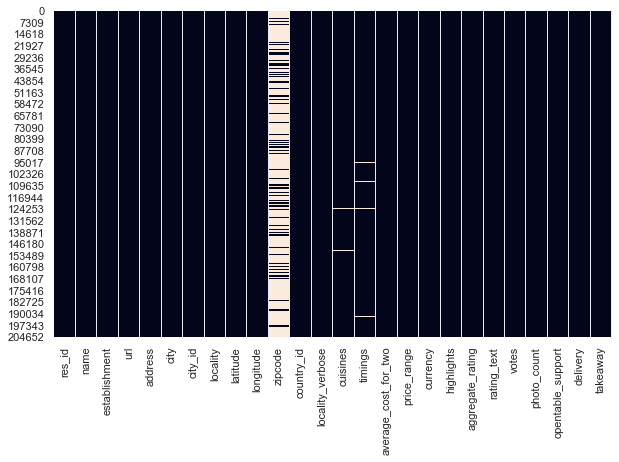

In [5]:
# Heatmap showing the data columns having null values
plt.figure(figsize = (10,6))
_ = sns.heatmap(data.isnull(), cbar=False)

- __Most of the missing data corresponds to the zipcode column, followed by timings. Thankfully neither of these features are critical in our analysis.__

## Remove duplicate entries
- Since the data was scraped from the API over many days, it is expected that many of the restaurant data will be duplicated over multiple days. So first we will clean the dataset by removing duplicating entries by restaurant ID.

In [6]:
print('There are {} duplicate entries'.format(data.duplicated('res_id').sum()))

There are 156376 duplicate entries


- Almost 74% of the data is duplicate! 

In [7]:
data = data.drop_duplicates(subset = 'res_id', keep = 'first')

In [8]:
data.shape

(55568, 26)

## Citywise distribution of restaurants

-Which are the top 10 cities by restaurant count in the dataset?

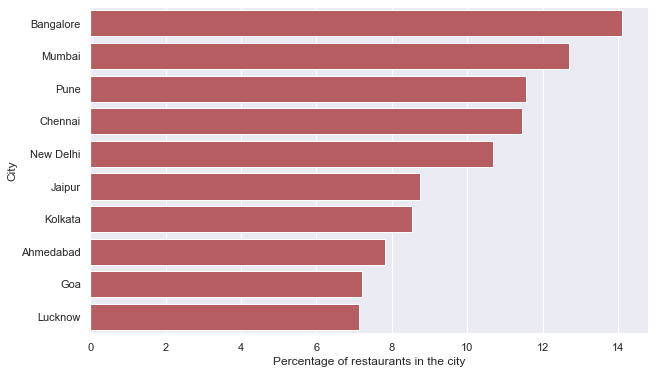

In [9]:
citywise_datacount_df = data.city.value_counts()
plt.figure(figsize = (10,6))
_ = sns.barplot(citywise_datacount_df[:10]/citywise_datacount_df[:10].values.sum()*100, citywise_datacount_df.index[:10],  orient= 'h', color= 'r')
_ = plt.xlabel('Percentage of restaurants in the city')
_ = plt.ylabel('City')

- As one can see from the chart above, about 14% of the restaurant are from the city of Bangalore, followed by ~12.5% from Mumbai. 

- The establishment type in the Zomato dataset basically refers to the category of the food joint, for e.g. is it a cafe, or a sweet shop, or a fast food joint, etc.

In [10]:
data.establishment.value_counts()

['Quick Bites']        14032
['Casual Dining']      12270
['Café']                4123
['Bakery']              3741
['Dessert Parlour']     3675
['Sweet Shop']          2615
['Beverage Shop']       2440
[]                      1830
['Fine Dining']         1535
['Food Court']          1494
['Bar']                 1399
['Dhaba']               1282
['Kiosk']               1126
['Food Truck']           868
['Lounge']               820
['Bhojanalya']           632
['Mess']                 361
['Pub']                  357
['Paan Shop']            320
['Confectionery']        218
['Butcher Shop']         154
['Club']                 112
['Microbrewery']         110
['Shack']                 20
['Cocktail Bar']          16
['Irani Cafe']            14
['Pop up']                 4
Name: establishment, dtype: int64

- Pretty interesting! But the quotation marks and the square brackets around the text sticks out like a sore thumb. Let's clean that up.

In [11]:
# Remove the square brackets and quotation marks around the phrases 

data['establishment'] = data.establishment.apply(lambda t: t[2:-2] if len(t)>2 else np.nan)
# data['establishment'] = data.establishment.apply(lambda x: re.findall(r'\w+\s?\w+', x)[0] if( x!='[]') else np.nan)

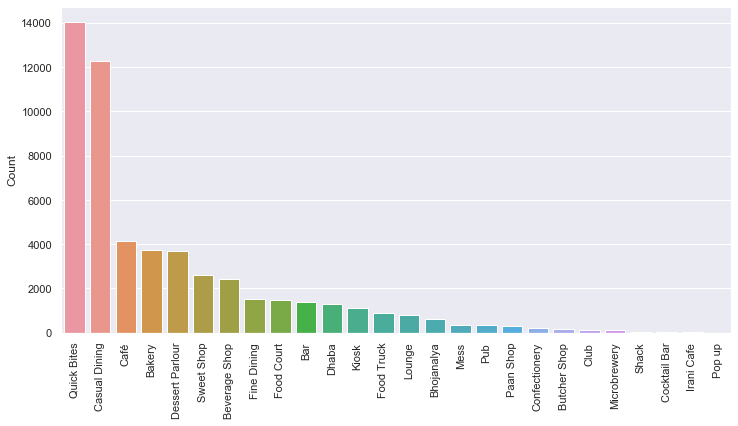

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(data.establishment.value_counts().index,data.establishment.value_counts())
_=plt.xticks(rotation=90)
_ = plt.ylabel('Count')

## Exploratory data analysis of Pune restaurants
- It makes sense to analyse the dataset for a particular city because it can offer more insights in to the ratings pattern, cuisine preferences, etc. 
- I have chosen **Pune** for my analysis. Why? Because it is the city I have been living in for the last 3 years! Furthermore, the Pune dataset is fairly large to extract some meaningful insights.

In [13]:
pune_data = data.loc[data.city =='Pune',:]

In [14]:
print('There are  {} restaurants available in the Pune dataset.'.format(pune_data.shape[0]))

There are  1843 restaurants available in the Pune dataset.


In [62]:
plt.figure(figsize=(10,6))
fig = px.histogram(pune_data.loc[pune_data.rating_text != 'Not rated', :], 
             title='Ratings distribution of Pune restaurants',x = 'aggregate_rating', 
             opacity = 0.6, marginal="box")
fig.show()

<Figure size 720x432 with 0 Axes>

- __The mean rating of the Pune restaurant is around 3.8, which is, well,  not too bad (?).__
- The ratings distribution looks bimodal with some low-rated restaurants clustered around a rating of 2.5, while the main peak/mode is around 3.8.

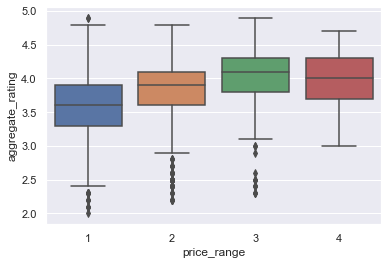

In [49]:
sns.scatterplot(x='average_cost_for_two', y='aggregate_rating', data=pune_data.loc[pune_data['aggregate_rating']>0, :])
sns.boxplot(x='price_range', y='aggregate_rating', data=pune_data.loc[pune_data['aggregate_rating']>0, :])

### Establishments

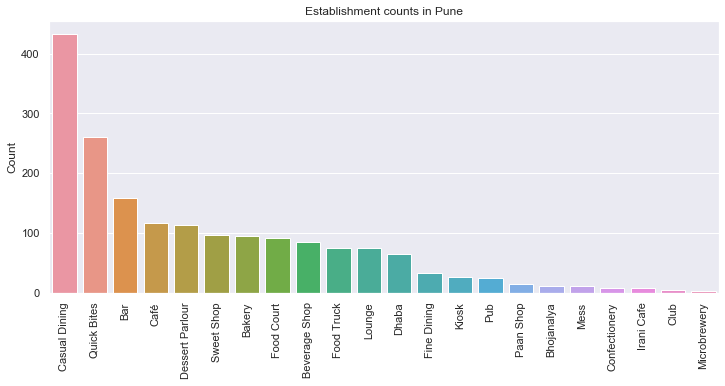

In [16]:
plt.figure(figsize=(12,5))
sns.barplot(pune_data.establishment.value_counts().index,pune_data.establishment.value_counts())
_=plt.xticks(rotation=90)
_ = plt.ylabel('Count')
_ = plt.title('Establishment counts in Pune')

- Puneities prefer to go for casual dining options or some quick snack joints. And they love their beer.

In [17]:
establishment_ratings = pune_data.loc[pune_data['rating_text']!= 'Not rated', :].groupby('establishment')['aggregate_rating'].agg(['mean','count','min','max']).sort_values('mean', ascending = False).query('count>20')
establishment_ratings

,mean,count,min,max
establishment,,,,
Fine Dining,4.125000,32,3.1,4.7
Bar,4.068153,157,2.2,4.9
Dessert Parlour,3.986607,112,2.3,4.9
Pub,3.945833,24,3.2,4.3
Casual Dining,3.898135,429,2.0,4.9
Café,3.893103,116,2.4,4.9
Bakery,3.795652,92,2.4,4.8
Lounge,3.680000,70,2.7,4.7
Quick Bites,3.655253,257,2.1,4.7


In [18]:
pune_data.loc[pune_data['rating_text']!= 'Not rated', :].groupby('establishment')[['aggregate_rating', 'average_cost_for_two']].agg({'aggregate_rating':['mean','count','min','max'], 'average_cost_for_two': ['mean']}).sort_values([('aggregate_rating','mean')], ascending = False)

aggregate_rating                 average_cost_for_two
                            mean count  min  max                 mean
establishment                                                        
Microbrewery            4.300000     2  4.2  4.4          1900.000000
Fine Dining             4.125000    32  3.1  4.7          2628.125000
Bar                     4.068153   157  2.2  4.9          1541.082803
Dessert Parlour         3.986607   112  2.3  4.9           295.982143
Pub                     3.945833    24  3.2  4.3          1552.083333
Casual Dining           3.898135   429  2.0  4.9          1030.815851
Café                    3.893103   116  2.4  4.9           640.948276
Club                    3.825000     4  3.5  4.3          1912.500000
Bakery                  3.795652    92  2.4  4.8           378.260870
Lounge                  3.680000    70  2.7  4.7          1685.000000
Quick Bites             3.655253   257  2.1  4.7           370.038911
Irani Cafe              3.628571     7  2.9  4.3           314.285714
Confectionery           3.600000     1  3.6  3.6          1000.000000
Beverage Shop           3.515068    73  2.8  4.8           270.547945
Food Truck              3.474545    55  2.1  4.9           329.454545
Sweet Shop              3.448913    92  2.6  4.3           254.347826
Kiosk                   3.446154    13  2.9  4.0           242.307692
Bhojanalya              3.400000     4  2.9  3.9           275.000000
Food Court              3.365217    92  2.2  4.2           418.478261
Mess                    3.300000     3  2.7  3.8           250.000000
Paan Shop               3.283333     6  3.1  3.7           175.000000
Dhaba                   3.216279    43  2.3  3.9           550.000000

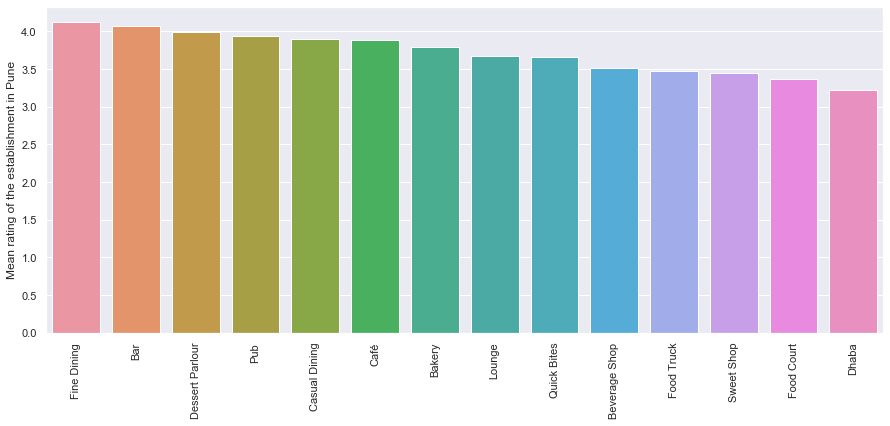

In [19]:
plt.figure(figsize = (15,6))
_ = sns.barplot(establishment_ratings.index, establishment_ratings['mean'])
_ = plt.xticks(rotation = 90)
_ = plt.ylabel('Mean rating of the establishment in Pune')
_ = plt.xlabel('')

#### It seems like bars in Pune enjoy very high ratings, just behind fine dining restaurants. Which are the top 5 bars you should choose to unwind after a long day?
Thank me later!

In [20]:
pune_data.loc[pune_data['establishment'] == 'Bar', ['name', 'aggregate_rating']].sort_values('aggregate_rating',ascending = False).drop_duplicates('name')[:5]

,name,aggregate_rating
164650,Agent Jack's,4.9
164660,Sentosa MultiCuisine Restaurant,4.8
164670,The FML Lounge,4.7
164671,Pop Tate's,4.7
164672,The Urban Foundry,4.7


In [56]:
px.box(pune_data.loc[pune_data['aggregate_rating']>0, :], x='establishment', y='aggregate_rating')

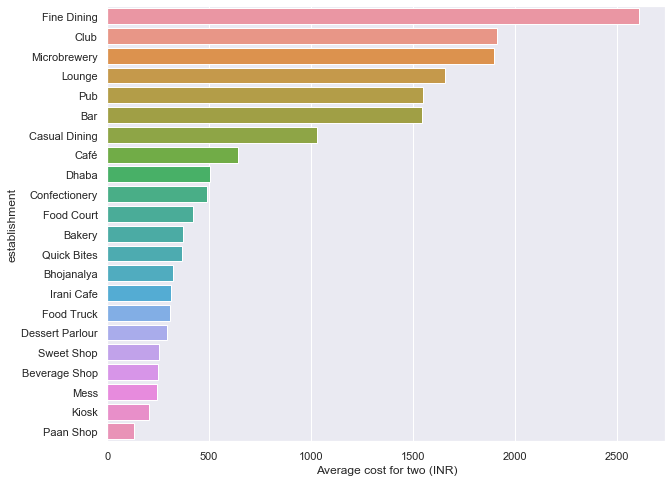

In [21]:
plt.figure(figsize = (10,8))
sorted_by_avgcost_ser = pune_data.groupby('establishment')['average_cost_for_two'].mean().sort_values(ascending = False)
_ = sns.barplot(sorted_by_avgcost_ser, sorted_by_avgcost_ser.index,  orient = 'h')
_ = plt.xlabel('Average cost for two (INR)')

### Takeaway and delivery support

In [22]:
map_binary = {1:1, -1:0}
pune_data.loc[:, 'delivery'] = pune_data['delivery'].copy().replace(map_binary)
pune_data.loc[:, 'takeaway'] = pune_data['takeaway'].copy().replace(map_binary)

/Users/debashis/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



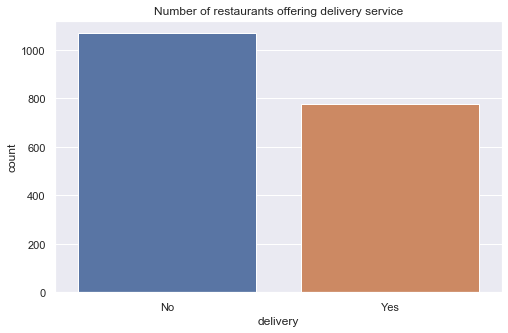

In [23]:
plt.figure(figsize = (8,5))
_ = sns.countplot(pune_data['delivery'])
_ = plt.xticks([0,1], labels = ['No', 'Yes'])
_ = plt.title('Number of restaurants offering delivery service')

## Cuisines

- Which cuisines do Puneities love the most? Let's find out!

In [24]:
cuisines_ser = pune_data.cuisines.apply(lambda cs: [c.strip() for c in cs.split(',')])
cuisines_ser

164447                                    [Japanese, Sushi]
164448      [Finger Food, Asian, Continental, North Indian]
164449                              [Mughlai, North Indian]
164450                                 [Asian, Continental]
164451                 [North Indian, Asian, Mediterranean]
                                ...                        
168657                                [Parsi, North Indian]
168658            [North Indian, Mughlai, Chinese, Seafood]
168659    [North Indian, Chinese, Mughlai, Biryani, Dess...
168660                       [Mughlai, North Indian, Asian]
168663                              [North Indian, Chinese]
Name: cuisines, Length: 1843, dtype: object

In [25]:
cuisines_list = []
for cuisine in cuisines_ser:
    cuisines_list = cuisines_list + cuisine

In [26]:
top_10_cuisines_df = pd.DataFrame(Counter(cuisines_list).most_common(10), columns= ['cuisine', 'count'])
top_10_cuisines_df

,cuisine,count
0,North Indian,680
1,Chinese,386
2,Fast Food,382
3,Desserts,315
4,Continental,311
5,Beverages,273
6,Italian,255
7,Street Food,211
8,Cafe,153
9,Asian,145


In [27]:
labels = top_10_cuisines_df['cuisine']
values = top_10_cuisines_df['count']
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4 ,hoverinfo="label+percent+value", pull =[0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0] )])
fig.update_layout(
    autosize=False,
    width= 800,
    height = 600,
    paper_bgcolor="whitesmoke",
)
fig.show()
#plt.figure(figsize = (8,8))
#explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0) 
#_ = plt.pie(top_10_cuisines_df['count'],  wedgeprops=dict(width=0.6),explode = explode, labels=top_10_cuisines_df['cuisine'], startangle = 90, autopct='%1.1f%%', shadow = True)
#_ = plt.axis('equal')

,average_cost_for_two,aggregate_rating
price_range,,
1,273.040142,3.174498
2,650.765864,3.582495
3,1360.502283,3.991096
4,2379.207921,3.895050


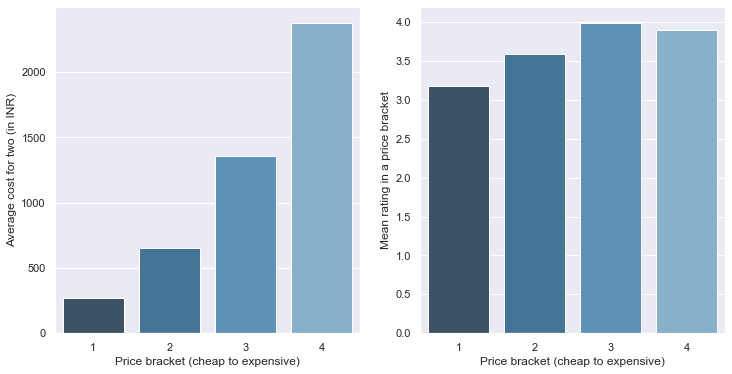

In [28]:
cost_ratings_df = pune_data.groupby('price_range')['average_cost_for_two', 'aggregate_rating'].mean()
display(cost_ratings_df)

fig, ax = plt.subplots(1,2, figsize=(12,6))
_ = sns.barplot(x=cost_ratings_df.index, y = 'average_cost_for_two', data = cost_ratings_df, palette = "Blues_d", ax=ax[0])
_ = sns.barplot(x=cost_ratings_df.index, y = 'aggregate_rating', data = cost_ratings_df, palette = "Blues_d", ax=ax[1])
_ = ax[0].set_xlabel('Price bracket (cheap to expensive)')
_ = ax[0].set_ylabel('Average cost for two (in INR)')
_ = ax[1].set_xlabel('Price bracket (cheap to expensive)')
_ = ax[1].set_ylabel('Mean rating in a price bracket')

In [29]:
top_10_restaurants_pune = pd.DataFrame(pune_data.name.value_counts()[:10]).reset_index()
px.bar(top_10_restaurants_pune, x = 'index', y = 'name')

## Locality

- Which are the top 10 localities in Pune with the highest number of restaurants?

In [30]:
top_10_localities = pune_data.groupby('locality').size().sort_values(ascending = False)[:10]
px.bar(top_10_localities.reset_index(name='count'), x='locality', y='count', width=800, height=500, 
       title = 'Number of restaurants by locality')

In [31]:
pune_data.groupby('locality')['price_range'].apply(lambda grp: np.mean(grp) if len(grp)>10 else np.nan).sort_values(ascending = False)[:10]

locality
Mundhwa                               2.760000
Balewadi High Street, Balewadi        2.666667
Ravet                                 2.363636
The Pavillion, Senapati Bapat Road    2.277778
Shivaji Nagar                         2.210526
Lonavala                              2.192308
Koregaon Park                         2.187500
Kalyani Nagar                         2.187500
Phoenix Market City, Viman Nagar      2.157895
Amanora Town Centre, Hadapsar         2.125000
Name: price_range, dtype: float64

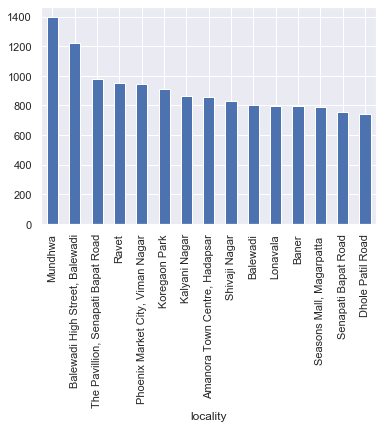

In [32]:
pune_data.groupby('locality')['average_cost_for_two'].apply(lambda grp: grp.mean() if len(grp) >10 else None).sort_values(ascending = False)[:15].plot.bar()
#_ = pune_data.locality.value_counts()[:10].plot.bar()

## Density of Pune restaurants
- Heatmap of restaurant locations.

In [33]:
mapbox_access_token = open("mapbox_token").read()
fig = go.Figure(go.Densitymapbox(lat= pune_data.latitude, lon = pune_data.longitude, 
                                 radius=8, text = pune_data['name']))
fig.update_layout(mapbox_style="light", mapbox_accesstoken=mapbox_access_token, 
                  mapbox_center_lat=18.55, mapbox_center_lon=73.8, mapbox_zoom=10,hovermode='closest')
fig.show()

### Three hotspots distinctively stand out from the plot above.
1. The Deccan area
2. Viman nagar (and parts of Kalyani Nagar) area
3. Baner-Aundh area

These areas are the heavens for foodies.

In [34]:
def scattermap_restaurants(data_df, city_name = 'Pune', lat = 18.55, lon = 73.7, zoom = 9, marker_size = 8):

    mapbox_access_token = open("mapbox_token").read()
    city_data = data_df.loc[data_df.city == city_name, :]
    data_clean_df = city_data.loc[(data['longitude']>0) & (city_data['rating_text']!= 'Not rated'), :]
    print('There are {} records in the dataset'.format(data_clean_df.shape[0]))

    fig = go.Figure(data=go.Scattermapbox(
        lon = data_clean_df['longitude'],
        lat = data_clean_df['latitude'],
        text = data_clean_df['name'] +', Rating: ' + 
    data_clean_df['aggregate_rating'].astype(str)+ '<br>' + data_clean_df['rating_text']
    + '<br>' + data_clean_df['cuisines'],
        mode = 'markers',
    marker=go.scattermapbox.Marker(
             size = marker_size, #symbol = 'marker', # can't use symbol with color
             color = data_clean_df['aggregate_rating'],
             opacity = 0.5, colorscale = 'viridis', colorbar_title = "Aggregate rating<br>of restaurants",#cmin=2        
             cauto=True
            )
        ))

    fig.update_layout(
     title = 'Restaurants in {}'.format(city_name),
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat = lat,
            lon = lon ),
        pitch=0,    #Sets the pitch angle of the map (in degrees, where "0" means perpendicular to the surface of the map) 
        zoom= zoom,
        style='light'
    ), 
    )
   
    fig.show()

scattermap_restaurants(data, city_name = 'Pune')

There are 1715 records in the dataset


#### What would be the distribution in my hometown Kolkata? I couldn't resist to find out.

In [35]:
scattermap_restaurants(data, city_name = 'Kolkata', lat=22.57,lon=88.36, zoom=9)

There are 1318 records in the dataset


In [36]:
delivery_avg_cost = pune_data.groupby('delivery')[['average_cost_for_two', 'price_range']].agg({'average_cost_for_two': 'mean', 'price_range': 'median'})
delivery_avg_cost.columns = ['average_cost_for_two', 'Median_price_range']
delivery_avg_cost

,average_cost_for_two,Median_price_range
delivery,,
0,800.388577,2
1,658.129032,2


In [37]:
takeaway_avg_cost = pune_data.groupby('takeaway')[['average_cost_for_two', 'price_range']].agg({'average_cost_for_two': 'mean', 'price_range': 'median'})
takeaway_avg_cost.columns = ['average_cost_for_two', 'Median_price_range']
takeaway_avg_cost

,average_cost_for_two,Median_price_range
takeaway,,
0,740.56701,2


- Interesting! What it basically says is that on an average, the more expensive restaurants do not offer delivery services. Understandable.

### Top highlights

In [38]:
s = ','.join(c for c in pune_data['highlights'])

In [39]:
highlight_count_df = pd.DataFrame(Counter([highlight.strip(' \'') for highlight in s.split(',')]).most_common(10), columns = ['Feature', 'Count'])
px.bar(highlight_count_df, 'Feature', 'Count')

In [40]:
scattermap_restaurants(pune_data.loc[pune_data.establishment == 'Bar', :])

There are 157 records in the dataset


In [41]:
pune_data.loc[pune_data.locality == 'Baner', 'cuisines']

164489    Continental, North Indian, Mughlai, Italian, A...
164492    Finger Food, North Indian, Mediterranean, Euro...
164569                                  Ice Cream, Desserts
164612                                  Desserts, Fast Food
164645                                             Desserts
                                ...                        
168598                   Mangalorean, Goan, Seafood, Konkan
168600                  Italian, Mexican, Chinese, American
168642                                        Maharashtrian
168647                                                Asian
168648                         Chinese, Asian, South Indian
Name: cuisines, Length: 100, dtype: object